In [2]:
!pip install ta
!pip install yfinance

  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=a437e5d3d198e7afab3bc9fc6e56503b9ae8744667fc0a23e41c36ac39343ecb
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 11.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium

In [3]:
#Importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from ta import add_all_ta_features
from ta.utils import dropna

#Extracts data from the yahoo finance and gives us the latest data
import yfinance as yf

#Importing Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Importing feature selection libraries
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA


#Importing libraries for LSTMs and defining accuracy
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import accuracy_score, r2_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
VOL = ['AAPL', 'WEI', 'TKAT', 'UNH', 'NVDA', 'GOOG']

In [5]:
#Returns X and y data in dataframe form processed and with TA lib features
#time is 10 years
def process_data(stock_name):
    start = datetime.datetime(2020,4,6)
    end = datetime.datetime(2022,4,6)
    stock = yf.download(stock_name,start,end)
    
    df = add_all_ta_features(
        stock, open="Open", high="High", low="Low", close="Close", volume="Volume")
    
    #Drops columns that have major null values
    
    df.drop(columns = ["trend_psar_up","trend_psar_down"], inplace = True)
    df.dropna(inplace = True)
    
    #Splits data into features and target values
    
    X = df.drop("Close",axis = 1)
    y = df["Close"]

    
    return X, y

In [6]:
# define the lasso regression class
class LassoRegression() :

  # define the constructor and pass
  # learning rate, iterations i.e epochs and l1 penality for Lasso
  def __init__( self, lr, epochs, l1_penality ) :

      self.lr = lr
      self.epochs = epochs
      self.l1_penality = l1_penality
      
  # fit the model on training data
  def fit( self, X, Y ) :
      
      # no_of_training_examples, no_of_features
      self.m, self.n = X.shape
      
      # weight initialization
      self.W = np.zeros( self.n )
      
      self.b = 0
      self.X = X
      self.Y = Y
      
      # gradient descent learning
      for i in range( self.epochs ) :
          self.update_weights()
      return self

  # function to update weights in gradient descent
  def update_weights( self ) :

      Y_pred = self.predict( self.X )
      
      # calculate gradients
      dW = np.zeros( self.n )

      # add or subtract penalty depending upon positivity or negativity of weights
      for j in range( self.n ):
          if self.W[j] > 0 :
              dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                      
                      + self.l1_penality ) / self.m
          else :
              dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                      
                      - self.l1_penality ) / self.m

      db = - 2 * np.sum( self.Y - Y_pred ) / self.m
      
      # update weights
      self.W = self.W - self.lr * dW
      self.b = self.b - self.lr * db
      
      return self

  # predict the output
  def predict( self, X ) :
      return X.dot( self.W ) + self.b

In [7]:
def perform_lasso(X_train, X_test):
  # Model training
  model = LassoRegression( epochs = 1000, lr = 0.01, l1_penality = 500 )
  model.fit( X_train, y_train )

  # Prediction on test set
  y_pred = model.predict( X_test )

  return model.W, X_train

In [8]:
from seaborn.utils import axes_ticklabels_overlap
def bar_importance(coeff, X_train, feature_names, thresh):

  # steps for feature importance
  feature_importance = np.std(X_train, 0)*np.array(coeff)
  
  above_threshold ={}
  # print feature name and their importance
  for name,importance in zip(feature_names,feature_importance):
      if abs(importance) >= thresh:
        above_threshold[name] = importance

  #create a dataframe containing feature name and their importance
  dff = pd.DataFrame([])
  dff['features'] = above_threshold.keys()
  dff['importance'] = above_threshold.values()

  d = dff.groupby(['features']).sum().sort_values('importance',ascending=False)
  
  # plot graph for feature importance
  d['importance'].plot.bar()
  return above_threshold

In [9]:
def create_model(X, y):
    
    #Defines the scaler for scaling down the data to values between 0 and 1. 
    scaler = MinMaxScaler()
    
    y = np.array(y)
    
    #Transforms the target data and feature data
        
    X_transformed = scaler.fit_transform(X)
    y_transformed = scaler.fit_transform(y.reshape(-1,1))
    
    #Splitting the data into training and testing
    
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.2, shuffle = None)
    
    train_len = len(X_train)
    test_len = len(X_test)
    
    X_train = np.array(X_train)
    X_train = X_train.reshape(train_len,-1,1)
    
    #Calls the make_model funtion that creates the sequential LSTM model
    predictor = make_model()
    
    #Trains the data on the new model with the training data for 10 epochs.
    predictor.fit(X_train, y_train, epochs = 10)
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(test_len,-1,1)
    y_test = np.reshape(y_test,(-1,1))
    
    #Here we calculate the predicted values using the trained data.
    
    y_pred = predictor.predict(X_test)
    
    #Inversing the transformed data to get the actual values matching to the real dataset
    
    y_pred_inv_transformed = scaler.inverse_transform(y_pred)
    y_actual_inv_transformed = scaler.inverse_transform(y_test)
    
    #Plotting the graph against the predicted values and real values
    plot_values(y_pred_inv_transformed, y_actual_inv_transformed)   
    
    #Calculating the r2 score to determine how accurate the model is.
    print("The r2 score of this prediction is : ", r2_score(y_actual_inv_transformed, y_pred_inv_transformed))

In [10]:
#Defining the LSTM and adding layers to it
def make_model():
    model = Sequential()
    model.add(LSTM(units = 180, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30))
    model.add(Dense(units = 1))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = "mae")
    
    return model

In [11]:
#The plot function here plots the predicted values against the actual values and displays the figure
def plot_values(pred_vals, actual_vals):
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(pred_vals)
    plt.plot(actual_vals)
    plt.show()
    plt.clf()

In [12]:
# Creates the training and testing sets from the dataframe 
X, y = process_data('NVDA')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)


[*********************100%***********************]  1 of 1 completed


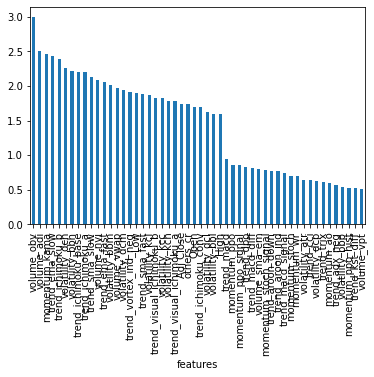

In [13]:
weight, X_train_refit = perform_lasso(X_train, X_test)
feature_names = X.columns

weight_thresh = 0.5
importance_dict = bar_importance(weight, X_train_refit, feature_names, weight_thresh)

#Keeping the columns that are most contributing from all the feature values

X = X.loc[:,list(importance_dict.keys())]


Epoch 1/10
11/11 [==============================] - 10s 203ms/step - loss: 0.0904 - mae: 0.2331
Epoch 2/10
11/11 [==============================] - 2s 202ms/step - loss: 0.0535 - mae: 0.1874
Epoch 3/10
11/11 [==============================] - 2s 199ms/step - loss: 0.0335 - mae: 0.1593
Epoch 4/10
11/11 [==============================] - 2s 198ms/step - loss: 0.0122 - mae: 0.0939
Epoch 5/10
11/11 [==============================] - 2s 197ms/step - loss: 0.0080 - mae: 0.0634
Epoch 6/10
11/11 [==============================] - 2s 195ms/step - loss: 0.0030 - mae: 0.0417
Epoch 7/10
11/11 [==============================] - 2s 199ms/step - loss: 0.0017 - mae: 0.0311
Epoch 8/10
11/11 [==============================] - 2s 203ms/step - loss: 0.0012 - mae: 0.0269
Epoch 9/10
11/11 [==============================] - 2s 202ms/step - loss: 0.0012 - mae: 0.0257
Epoch 10/10
11/11 [==============================] - 2s 200ms/step - loss: 9.9183e-04 - mae: 0.0241


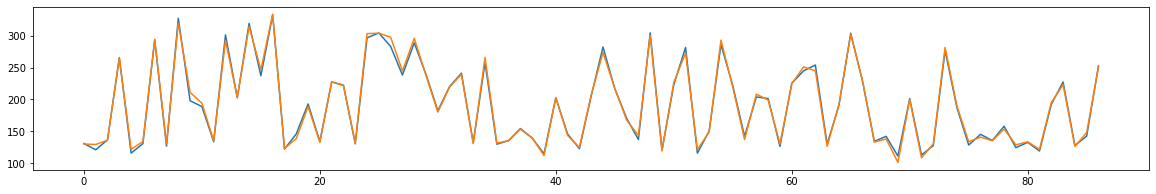

<Figure size 1440x216 with 0 Axes>

The r2 score of this prediction is :  0.9946866396599172


In [14]:
create_model(X, y)